
# File descriptions

**Data Description**

In this competition, you will be analyzing weather data and GIS data and predicting whether or not West Nile virus is present, for a given time, location, and species. 

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

**Main dataset**

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

**Spray Data**

The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

**Weather Data**

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level


In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn  
from __future__ import division
import seaborn as sns

In [13]:
train=pd.read_csv("./west_nile/input/train.csv")
train.set_index('Date', inplace=True)
train.index=pd.to_datetime(train.index)
train.sort_index(inplace=True)

train.head()

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


The train set contain the following columns:

**Id:** the id of the record  
**Date:** date that the WNV test is performed  
**Address:** approximate address of the location of trap. This is used to send to the GeoCoder.   
**Species:** the species of mosquitos  
**Block:** block number of address  
**Street:** street name  
**Trap:** Id of the trap  
**AddressNumberAndStreet:** approximate address returned from GeoCoder  
**Latitude, Longitude:** Latitude and Longitude returned from GeoCoder  
**AddressAccuracy:** accuracy returned from GeoCoder  
**NumMosquitos:** number of mosquitoes caught in this trap  
**WnvPresent:** whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present.   



In [3]:
train["AddressAccuracy"].value_counts()

8    4628
9    3980
5    1807
3      91
Name: AddressAccuracy, dtype: int64

In [4]:
train.shape

(10506, 11)

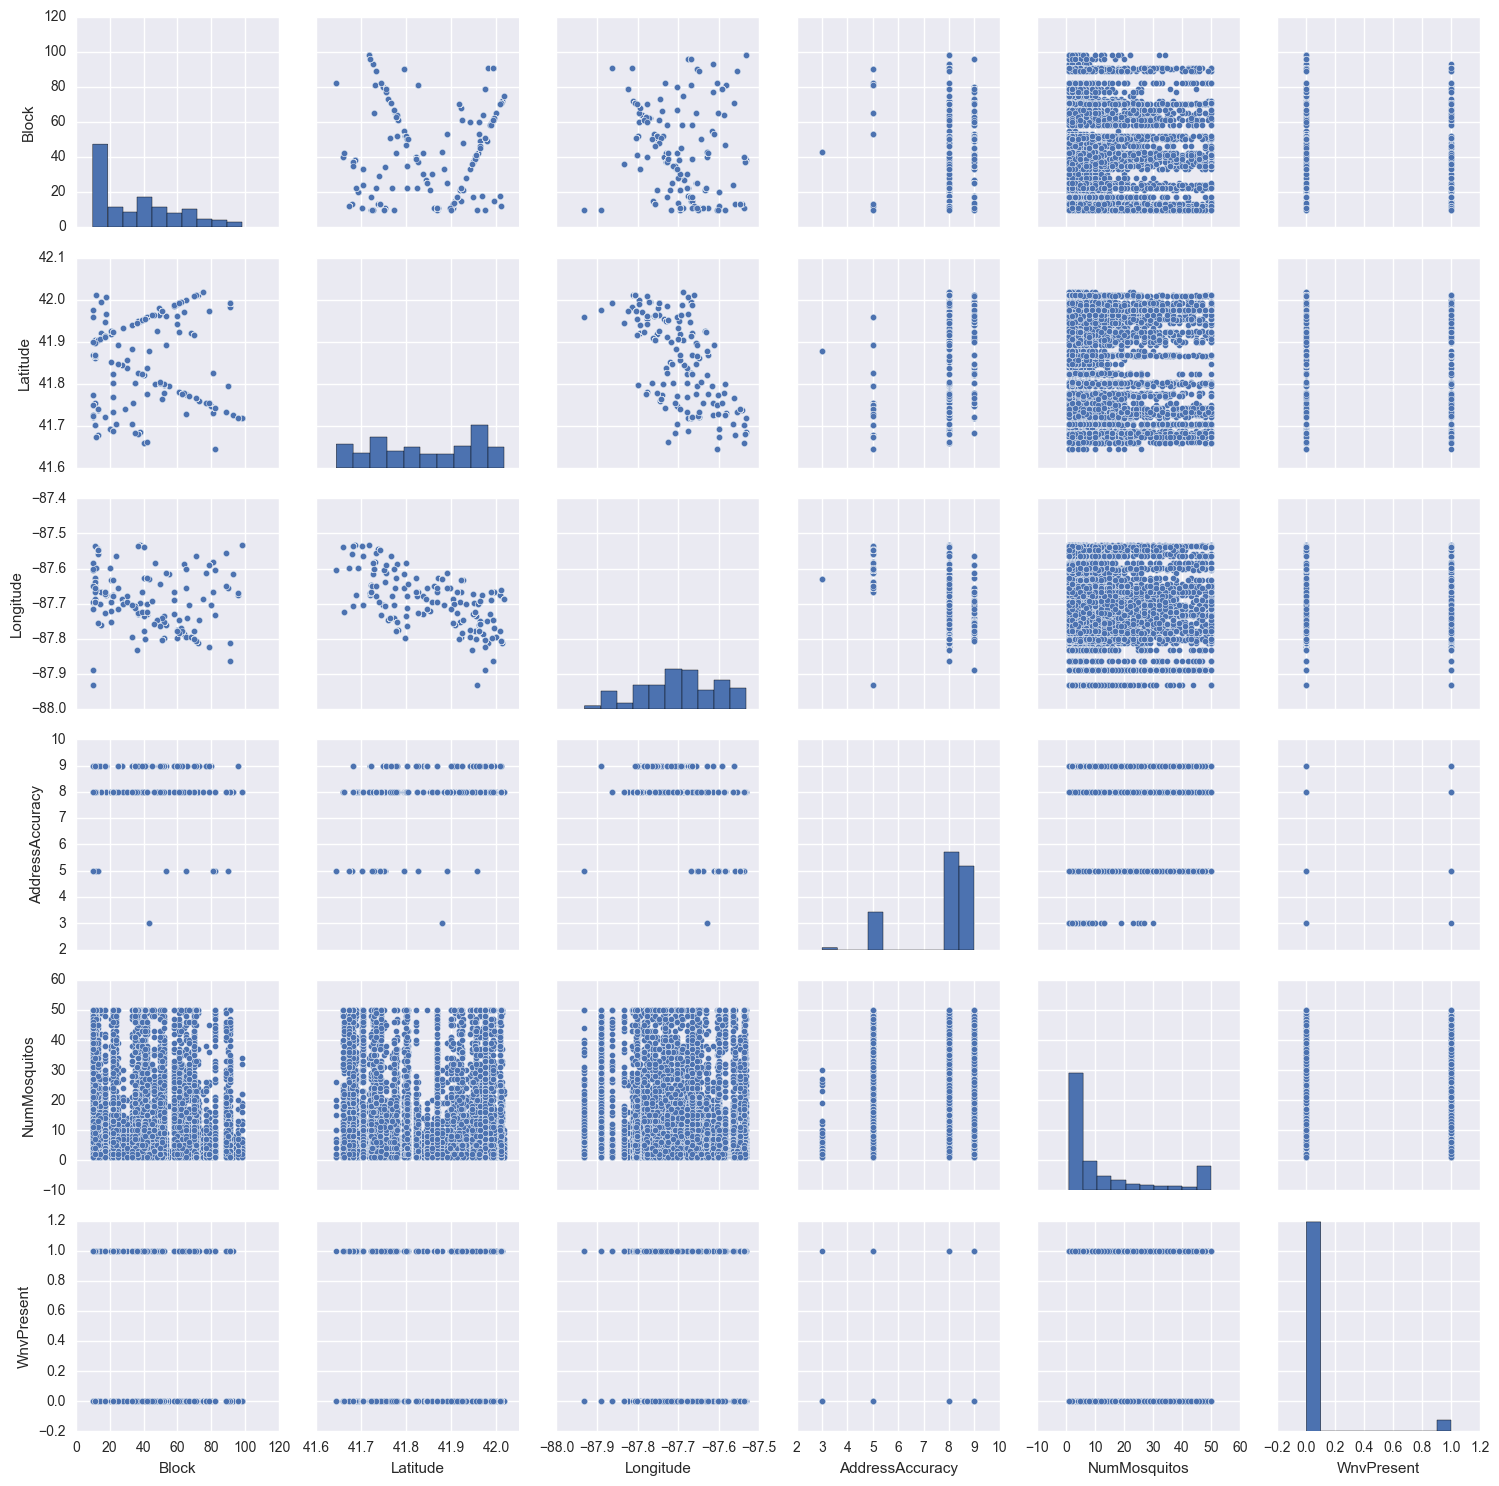

In [5]:
sns.pairplot(train)
plt.show()

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 11 columns):
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 984.9+ KB


In [7]:
weather=pd.read_csv("./west_nile/input/weather.csv")
weather.sort('Date',inplace=True)
weather.set_index('Date', inplace=True)
weather.index=pd.to_datetime(weather.index)
weather.head()

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56,2,40,48,9,0,0446,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [8]:
spray=pd.read_csv("./west_nile/input/spray.csv")
spray.set_index('Date', inplace=True)
spray.index=pd.to_datetime(spray.index)
spray.sort_index(inplace=True,ascending=True)
spray.head()

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Time,Latitude,Longitude
Date,,,
2011-08-29,6:56:58 PM,42.391623,-88.089163
2011-08-29,7:09:58 PM,42.390335,-88.096443
2011-08-29,7:09:48 PM,42.390642,-88.096440
2011-08-29,7:09:38 PM,42.390952,-88.096437
2011-08-29,7:09:28 PM,42.391238,-88.096468


In [11]:
spray.shape

(14835, 3)